In [1]:
# uncomment the line below to make matplotlib plots dynamic
#%matplotlib notebook
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
# older versions of Jupyter may need wurlitzer in order to redirect the C output to the notebook 
#%load_ext wurlitzer

from xspec import *

## Using XSPEC to Simulate Data: an Example for Chandra

In several cases, analyzing simulated data is a powerful tool to demonstrate feasibility. For example:

    To support an observing proposal. That is, to demonstrate what constraints a proposed observation would yield.
    To support a hardware proposal. If a response matrix is generated, it can be used to demonstrate what kind of science could be done with a new instrument.
    To support a theoretical paper. A theorist could write a paper describing a model, and then show how these model spectra would appear when observed. This, of course, is very like the first case.

Here, we will illustrate the first example. The first step is to define a model on which to base the simulation. The way XSPEC creates simulated data is to take the current model, convolve it with the current response matrix, while adding noise appropriate to the integration time specified. Once created, the simulated data can be analyzed in the same way as real data to derive confidence limits.

Let us suppose that we want to measure the intrinsic absorption of a faint high-redshift source using Chandra. Our model is thus a power-law absorbed both by the local Galactic column and an intrinsic column. The response matrices were obtained from the HEASARC and are available from https://heasarc.gsfc.nasa.gov/docs/xanadu/xspec/walkthrough.tar.gz

This version of the notebook does all plotting through matplotlib.

First, we set up the model. From the literature we have the Galactic absorption column and redshift so:


In [2]:
m1 = Model("tbabs*zphabs(zpow)", setPars=(0.08,1.0,5.1,1.7,5.1,1.0))


Model TBabs<1>*zphabs<2>*zpowerlw<3> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   TBabs      nH         10^22    1.00000      +/-  0.0          
   2    2   zphabs     nH         10^22    1.00000      +/-  0.0          
   3    2   zphabs     Redshift            0.0          frozen
   4    3   zpowerlw   PhoIndex            1.00000      +/-  0.0          
   5    3   zpowerlw   Redshift            0.0          frozen
   6    3   zpowerlw   norm                1.00000      +/-  0.0          
________________________________________________________________________



tbvabs Version 2.3
Cosmic absorption with grains and H2, modified from
Wilms, Allen, & McCray, 2000, ApJ 542, 914-924
Questions: Joern Wilms
joern.wilms@sternwarte.uni-erlangen.de
joern.wilms@fau.de

http://pulsar.sternwarte.uni-erlangen.de/wilms/research/tbabs/

PLEASE NOTICE:
To get the model described by the above paper
you will also have to set the abundances:
   abund wilm

Note that this routine ignores the current cross section setting
as it always HAS to use the Verner cross sections as a baseline.



Model TBabs<1>*zphabs<2>*zpowerlw<3> Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   TBabs      nH         10^22    8.00000E-02  +/-  0.0          
   2    2   zphabs     nH         10^22    1.00000      +/-  0.0          
   3    2   zphabs     Redshift            5.10000      frozen
   4    3   zpowerlw   PhoIndex            1.70000      +/-  0.0          
   5    3   zpowerlw   Redshift            5.10000      frozen
   6    3   zpowerlw   norm                1.00000      +/-  0.0          
________________________________________________________________________



Now suppose that we know that the observed 0.5-2.5 keV flux is $1.1\times10^{-13}$ ergs/cm$^2$/s. We calculate the flux in that energy range for a normalization of 1.0 and determine the new normalization and set it.


In [3]:
AllModels.setEnergies("0.5 2.5 1000")
AllModels.calcFlux("0.5 2.5")
newNorm = 1.1e-13/m1.flux[0]
m1.zpowerlw.norm = newNorm
AllModels.calcFlux("")


Models will now use energy array created from:
   0.5 - 2.5   1000 linear bins

 Upper range bound          2.5 reset by matrix bound to          2.5
 Model Flux  0.053162 photons (1.0066e-10 ergs/cm^2/s) range (0.50000 - 2.5000 keV)
 Upper range bound          2.5 reset by matrix bound to          2.5
 Model Flux 5.8096e-05 photons (1.1e-13 ergs/cm^2/s) range (0.50000 - 2.5000 keV)


The simulation is set up FakeitSettings object giving the response to be used and the exposure time. We also need to reset the energies command before the fakeit to ensure that the model is calculated on the entire energy range of the response.

In [4]:
%cd data
fs = FakeitSettings(response="aciss_aimpt_cy15.rmf", arf="aciss_aimpt_cy15.arf", exposure=40000.0, fileName="test.fak")
AllModels.setEnergies("reset")

/Users/karnaud/GitHub/PyXspec-Jupyter-notebooks/data

All model energies will be taken from non-extended response energies.



In [5]:
AllData.fakeit(1,fs)

xsFakeit cmd string:
fakeit 1 & aciss_aimpt_cy15.rmf & aciss_aimpt_cy15.arf & y & / & test.fak & 40000.0, ,  


No background will be applied to fake spectrum #1

1 spectrum  in use
 

Fit statistic  : Chi-Squared                  335.61     using 1024 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared                  335.61     using 1024 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 1.00e+00 with 1020 degrees of freedom
 Current data and model not fit yet.


The first thing we should note is that the default statistics are not correct for these data. For Poisson data and no background we should use cstat for the fit statistic and pchi for the test statistic: 

In [6]:
Fit.statMethod = "cstat"
Fit.statTest = "pchi"

Default fit statistic is set to: C-Statistic
   This will apply to all current and newly loaded spectra.

Fit statistic  : C-Statistic                  494.29     using 1024 bins.

Test statistic : Chi-Squared                  335.61     using 1024 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 1.00e+00 with 1020 degrees of freedom
 Current data and model not fit yet.
Test statistic is set to: Pearson Chi-Squared

Fit statistic  : C-Statistic                  494.29     using 1024 bins.

Test statistic : Pearson Chi-Squared          753.17     using 1024 bins.

***Warning: Pearson Chi-square may not be valid due to bins with zero model value
            in spectrum number(s): 1 

 Null hypothesis probability of 1.00e+00 with 1020 degrees of freedom
 Current data and model not fit yet.


As we can see from the warning message we need to ignore some channels where there is no effective response. Looking at a plot of the data and model indicates we should ignore below 0.15 keV and above 10 keV so: 

***Warning: Fit is not current.


<ErrorbarContainer object of 3 artists>

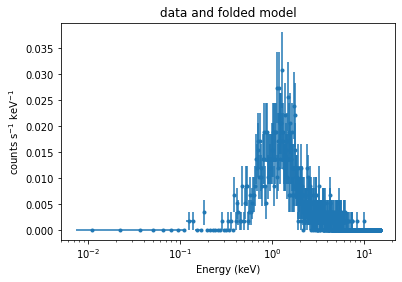

In [7]:
Plot.device = "/null"
Plot.xAxis = "keV"
Plot("data")
energies = Plot.x()
edeltas = Plot.xErr()
rates = Plot.y()
errors = Plot.yErr()
labels = Plot.labels()
plt.xscale('log')
plt.xlabel(labels[0])
plt.ylabel(labels[1])
plt.title(labels[2])
plt.errorbar(energies,rates,xerr=edeltas,yerr=errors,fmt='.')

Looking at a plot of the data and model indicates we should ignore below 0.15 keV and above 10 keV so: 

In [8]:
AllData.ignore("**-0.15 10.0-**")

    11 channels (1-11) ignored in spectrum #     1
   340 channels (685-1024) ignored in spectrum #     1

Fit statistic  : C-Statistic                  490.68     using 673 bins.

Test statistic : Pearson Chi-Squared          747.61     using 673 bins.
 Null hypothesis probability of 1.84e-02 with 669 degrees of freedom
 Current data and model not fit yet.



We assume that the Galactic column is known so freeze the first parameter. We then perform a fit and estimate the uncertainty in the parameters.

In [9]:
m1.TBabs.nH.frozen = True
Fit.perform()


Fit statistic  : C-Statistic                  490.68     using 673 bins.

Test statistic : Pearson Chi-Squared          747.61     using 673 bins.
 Null hypothesis probability of 1.96e-02 with 670 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
C-Statistic  |beta|/N    Lvl          2:nH    4:PhoIndex        6:norm
488.055      8.90682      -2      0.293603       1.63324   0.000890066
487.584      6591.14      -3      0.129188       1.60083   0.000830864
487.532      2798.69      -4     0.0639318       1.60083   0.000833495
487.527      655.249      -5     0.0270609       1.60179   0.000835848
 Variances and Principal Axes
                 2        4        6  
 5.8428E-10| -0.0000  -0.0019   1.0000  
 2.3976E-03|  0.0350  -0.9994  -0.0019  
 1.5269E+00|  0.9994   0.0350   0.0001  
----------------------------------------

  Covariance Matrix
        1           2           3   
   1.525e+00   5.330e-02   1.286e-04
   5.330e-02   4.

In [10]:
Xset.parallel.error = 3
Fit.error("2 4 6")

 Parameter   Confidence Range (2.706)
***Warning: Zero alpha-matrix diagonal element for parameter 2
 Parameter 2 is pegged at 4.22386e-07 due to zero or negative pivot element, likely
 caused by the fit being insensitive to the parameter.
***Warning: Zero alpha-matrix diagonal element for parameter 2
 Parameter 2 is pegged at 4.22386e-07 due to zero or negative pivot element, likely
 caused by the fit being insensitive to the parameter.
     2            0      1.96182    (-0.0433503,1.91847)
     4      1.52116       1.7041    (-0.0811416,0.101798)
     6  0.000689429   0.00108854    (-0.000147676,0.000251438)


***Warning: Parameter pegged at hard limit: 0


<ErrorbarContainer object of 3 artists>

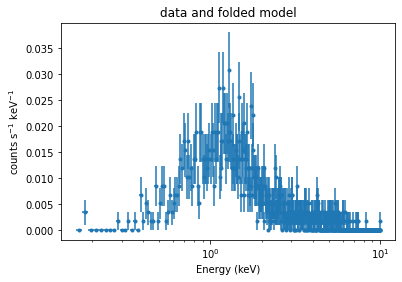

In [11]:
Plot("data")
energies = Plot.x()
edeltas = Plot.xErr()
rates = Plot.y()
errors = Plot.yErr()
labels = Plot.labels()
plt.xscale('log')
plt.xlabel(labels[0])
plt.ylabel(labels[1])
plt.title(labels[2])
plt.errorbar(energies,rates,xerr=edeltas,yerr=errors,fmt='.')

Now let's make this plot look a bit better. The current bin sizes are much smaller than the resolution so we may as well combine bins in the plot (but not in the fitting) to make it clearer. The first argument of the setRebin method is the minimum number of sigma and the second the maximum number of channels to bin up. So in this case the minimum sigma is set very high to ensure that there is a uniform binning of 4. We set the y-axis to logarithmic and choose appropriate x-axis and y-axis limits. 

<ErrorbarContainer object of 3 artists>

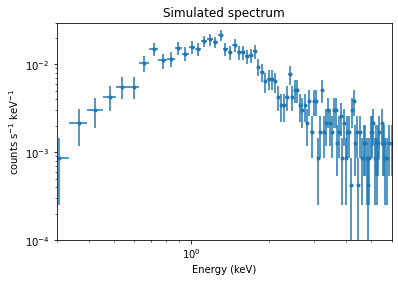

In [15]:
Plot.setRebin(100,4)
Plot.yLog = True
Plot("data")
energies = Plot.x()
edeltas = Plot.xErr()
rates = Plot.y()
errors = Plot.yErr()
labels = Plot.labels()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(labels[0])
plt.ylabel(labels[1])
plt.title('Simulated spectrum')
plt.xlim([0.3,6.0])
plt.ylim([1.0e-4,0.03])
plt.errorbar(energies,rates,xerr=edeltas,yerr=errors,fmt='.')